# Integrated Gradients可解释性分析

使用Integrated Gradients，在输入图像上，对指定类别进行可解释性分析。

同济子豪兄 https://space.bilibili.com/1900783

代码运行云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1

2022-8-19

## 导入工具包

In [1]:
import os
import json
import numpy as np
import pandas as pd

from PIL import Image

import torch
import torch.nn.functional as F
import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
# from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入预训练ResNet模型

In [2]:
model = models.resnet18(pretrained=True)
model = model.eval().to(device)

## 载入ImageNet 1000图像分类标签

In [3]:
import pandas as pd
df = pd.read_csv('imagenet_class_index.csv')
idx_to_labels = {}
idx_to_labels_cn = {}
for idx, row in df.iterrows():
    idx_to_labels[row['ID']] = row['class']
    idx_to_labels_cn[row['ID']] = row['Chinese']

In [4]:
# idx_to_labels

## 图像预处理

In [5]:
from torchvision import transforms

# 缩放、裁剪、转 Tensor、归一化
transform_A = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),          
    transforms.ToTensor()         
])

transform_B = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

## 载入测试图像

In [6]:
img_path = 'test_img/swan-3299528_1280.jpg'

In [7]:
img_pil = Image.open(img_path)

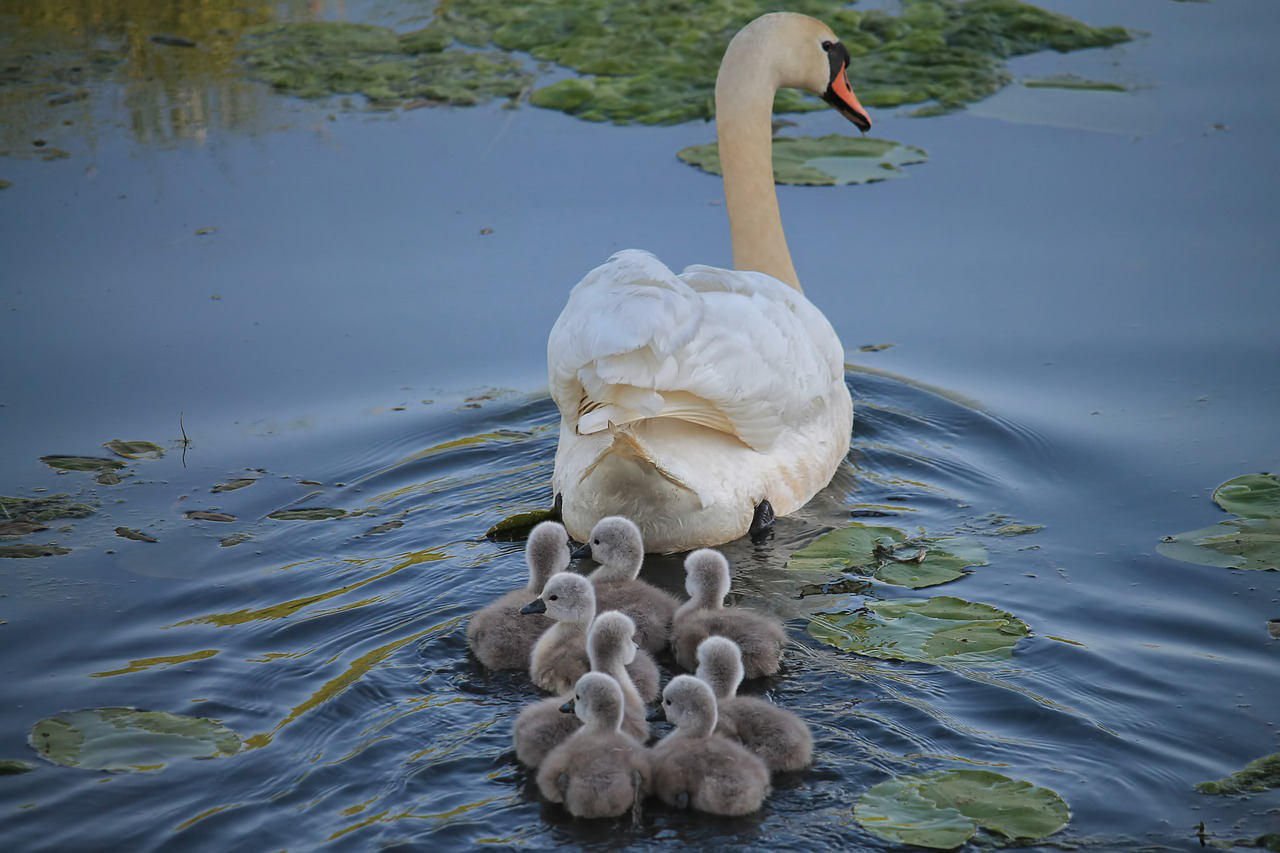

In [8]:
img_pil

## 预处理

In [9]:
# 缩放、裁剪
rc_img = transform_A(img_pil)

# 调整数据维度
rc_img_norm = np.transpose(rc_img.squeeze().cpu().detach().numpy(), (1,2,0))

# 色彩归一化
input_tensor = transform_B(rc_img).unsqueeze(0).to(device)

## 前向预测

In [10]:
pred_logits = model(input_tensor)
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

pred_conf, pred_id = torch.topk(pred_softmax, 1)
pred_conf = pred_conf.detach().cpu().numpy().squeeze().item()
pred_id = pred_id.detach().cpu().numpy().squeeze().item()
pred_label = idx_to_labels[pred_id]

print('预测类别的ID {} 名称 {} 置信度 {:.2f}'.format(pred_id, pred_label, pred_conf))

预测类别的ID 99 名称 goose 置信度 0.46


## Integrated Gradients可解释性分析

Integrated Gradients 原理

输入图像像素由空白变为输入图像像素的过程中，`模型预测为某一特定类别的概率`相对于`输入图像像素`的梯度积分。

In [11]:
# 初始化可解释性分析方法
integrated_gradients = IntegratedGradients(model)

### 单张图像

In [12]:
# 获得输入图像每个像素的 IG 值
attributions_ig = integrated_gradients.attribute(input_tensor, target=pred_id, n_steps=200)

In [13]:
attributions_ig.shape

torch.Size([1, 3, 224, 224])

In [15]:
# 转为 224 x 224 x 3的数据维度
attributions_ig_norm = np.transpose(attributions_ig.detach().cpu().squeeze().numpy(), (1,2,0))

In [16]:
attributions_ig_norm.shape

(224, 224, 3)

In [17]:
attributions_ig_norm[:, :, 0].shape

(224, 224)

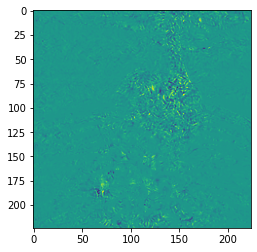

In [18]:
plt.imshow(attributions_ig_norm[:, :, 0] * 100)
# plt.imshow(attributions_ig_norm[:, :, 1] * 100)
# plt.imshow(attributions_ig_norm[:, :, 2] * 100)
plt.show()

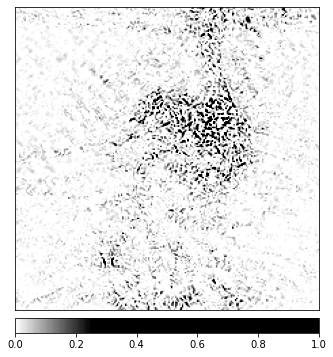

In [19]:
# 设置配色方案
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

# 可视化 IG 值
viz.visualize_image_attr(attributions_ig_norm, # 224,224,3
                         rc_img_norm,          # 224,224,3
                         method='heat_map',
                         cmap=default_cmap,
                         show_colorbar=True,
                         sign='positive',
                         outlier_perc=1)
plt.show()

### 加入高斯噪声的多张图像，平滑输出

在输入图像中加入高斯噪声，构造`nt_samples`个噪声样本，分别计算IG值，再使用`smoothgrad_sq（先平均再平方）`平滑。

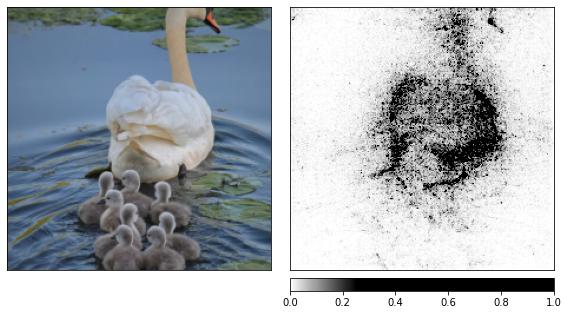

In [ ]:
noise_tunnel = NoiseTunnel(integrated_gradients)

# 获得输入图像每个像素的 IG 值
attributions_ig_nt = noise_tunnel.attribute(input_tensor, nt_samples=12, nt_type='smoothgrad_sq', target=pred_id)

# 转为 224 x 224 x 3的数据维度
attributions_ig_nt_norm = np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0))

# 设置配色方案
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

viz.visualize_image_attr_multiple(attributions_ig_nt_norm, # 224 224 3
                                  rc_img_norm, # 224 224 3
                                  ["original_image", "heat_map"],
                                  ["all", "positive"],
                                  cmap=default_cmap,
                                  show_colorbar=True)
plt.show()

如果报错`RuntimeError: CUDA out of memory.`，GPU显存不足，解决方案：

1.设置更小的`nt_samples`参数

2.更换显存更大的云GPU实例

3.重启所有kernel后，跳过`单张图像`代码块，直接运行本代码块。